In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from keras.models import Sequential
import matplotlib.patches as mpatches
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os


In [3]:
data = pd.read_csv('C:/Users/PC1/Desktop/testset.csv')

In [4]:
data.columns

Index(['datetime_utc', ' _conds', ' _dewptm', ' _fog', ' _hail',
       ' _heatindexm', ' _hum', ' _precipm', ' _pressurem', ' _rain', ' _snow',
       ' _tempm', ' _thunder', ' _tornado', ' _vism', ' _wdird', ' _wdire',
       ' _wgustm', ' _windchillm', ' _wspdm'],
      dtype='object')

In [5]:
data['datetime_utc'] = pd.to_datetime(data['datetime_utc'])
data.set_index('datetime_utc', inplace= True)
data =data.resample('D').mean()

In [6]:
data = data[[' _tempm' ]]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7480 entries, 1996-11-01 to 2017-04-24
Freq: D
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0    _tempm  7336 non-null   float64
dtypes: float64(1)
memory usage: 116.9 KB


In [8]:
from scipy.interpolate import interp1d

In [9]:
data[' _tempm'] = data[' _tempm'].interpolate()# we will fill the null row

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7480 entries, 1996-11-01 to 2017-04-24
Freq: D
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0    _tempm  7480 non-null   float64
dtypes: float64(1)
memory usage: 116.9 KB


In [11]:
data.head(100000)

,_tempm
datetime_utc,
1996-11-01,22.333333
1996-11-02,22.916667
1996-11-03,21.791667
1996-11-04,22.722222
1996-11-05,27.800000
...,...
2017-04-20,34.500000
2017-04-21,34.250000
2017-04-22,32.900000


In [142]:
df = data.copy()

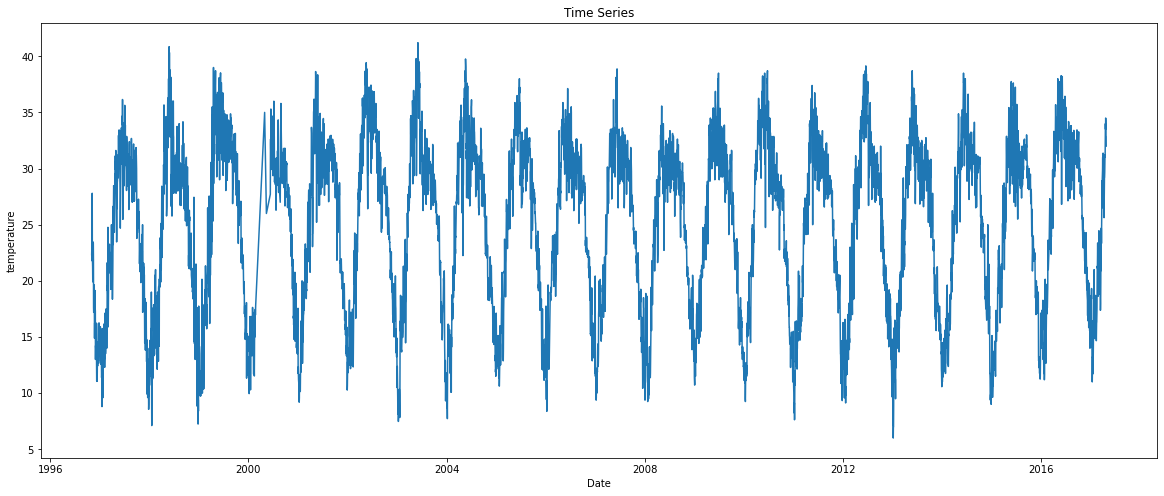

In [143]:
plt.figure(figsize=(20,8))
plt.plot(data)
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('temperature')
plt.show()

In [144]:
data=data.values
data = data.astype('float32')

In [145]:
scaler= MinMaxScaler(feature_range=(-1,1))
sc = scaler.fit_transform(data)

In [146]:
sc

array([[-0.07224715],
       [-0.03911316],
       [-0.10301447],
       ...,
       [ 0.5279522 ],
       [ 0.5265322 ],
       [ 0.47683108]], dtype=float32)

In [147]:
timestep = 30

X= []
Y=[]


for i in range(len(sc)- (timestep)):
    X.append(sc[i:i+timestep])
    Y.append(sc[i+timestep])


X=np.asanyarray(X)
Y=np.asanyarray(Y)


k = 7300
Xtrain = X[:k,:,:]
Xtest = X[k:,:,:]    
Ytrain = Y[:k]    
Ytest= Y[k:]

In [148]:
print(Xtrain.shape)
print(Xtest.shape)

(7300, 30, 1)
(150, 30, 1)


In [149]:
from keras.layers import Dense,RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [150]:
model = Sequential()

model.add(LSTM(32,activation = 'relu', input_shape= (30,1), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='sigmoid', return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [151]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 30, 32)            4352      
_________________________________________________________________
lstm_10 (LSTM)               (None, 30, 32)            8320      
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [152]:
history = model.fit(Xtrain,Ytrain,epochs=50, verbose=1)

Epoch 1/50
229/229 [==============================] - ETA: 0s - loss: 0.040 - 15s 39ms/step - loss: 0.0400
Epoch 2/50
229/229 [==============================] - 9s 40ms/step - loss: 0.0139
Epoch 3/50
229/229 [==============================] - 9s 37ms/step - loss: 0.0110
Epoch 4/50
229/229 [==============================] - 9s 40ms/step - loss: 0.0102
Epoch 5/50
229/229 [==============================] - 9s 39ms/step - loss: 0.0095
Epoch 6/50
229/229 [==============================] - 9s 40ms/step - loss: 0.0094
Epoch 7/50
229/229 [==============================] - 9s 38ms/step - loss: 0.0099
Epoch 8/50
229/229 [==============================] - 9s 40ms/step - loss: 0.0092
Epoch 9/50
229/229 [==============================] - 10s 43ms/step - loss: 0.0099
Epoch 10/50
229/229 [==============================] - 9s 38ms/step - loss: 0.0093
Epoch 11/50
229/229 [==============================] - 9s 39ms/step - loss: 0.0092: 0s - loss:
Epoch 12/50
229/229 [==============================] - 10s

Text(0.5, 1.0, 'Model Accuracy')

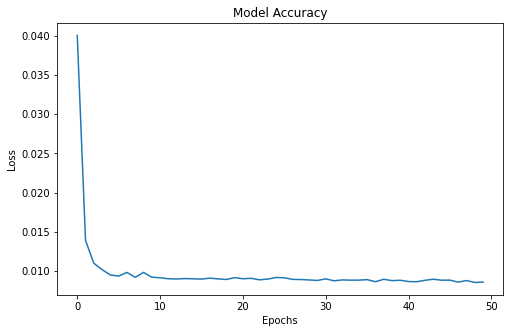

In [153]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Accuracy")

In [154]:
model

In [155]:
preds= model.predict(Xtest)
preds = scaler.inverse_transform(preds)


Ytest=np.asanyarray(Ytest)  
Ytest=Ytest.reshape(-1,1) 
Ytest = scaler.inverse_transform(Ytest)


Ytrain=np.asanyarray(Ytrain)  
Ytrain=Ytrain.reshape(-1,1) 
Ytrain = scaler.inverse_transform(Ytrain)

mean_squared_error(Ytest,preds)


2.7641969

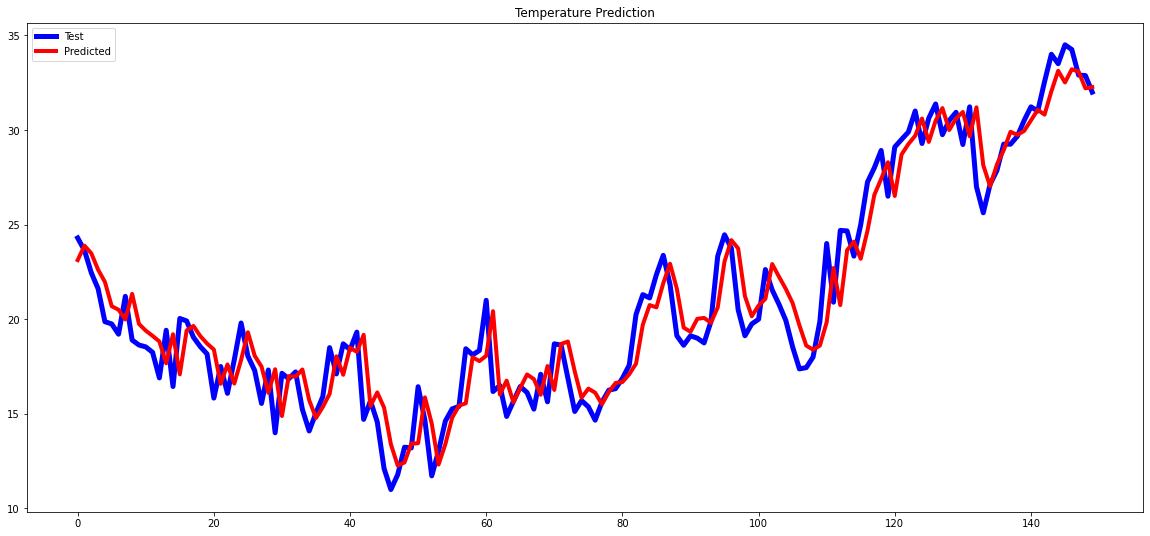

In [156]:
plt.figure(figsize=(20,9))
plt.plot(Ytest , 'blue', linewidth=5)
plt.plot(preds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("Temperature Prediction")
plt.show()

In [157]:
test = pd.DataFrame(Ytest,columns=['Actual'])
pred = pd.DataFrame(preds,columns=['Predict'])

In [158]:
results = pd.concat([test,pred],axis=1)

In [159]:
results.head(20)

,Actual,Predict
0,24.294117,23.124006
1,23.636364,23.888176
2,22.454546,23.482889
3,21.611111,22.615955
4,19.869566,21.971556
5,19.750000,20.687805
6,19.208334,20.501312
7,21.208334,19.987600
8,18.900000,21.338930
9,18.636364,19.750450


In [160]:
def insert_end(Xin,new_input):
    print ('Before: \n', Xin , new_input )
    for i in range(timestep-1):
        Xin[:,i,:] = Xin[:,i+1,:]
    Xin[:,timestep-1,:] = new_input
    print ('After :\n', Xin)
    return Xin

In [161]:
df

,_tempm
datetime_utc,
1996-11-01,22.333333
1996-11-02,22.916667
1996-11-03,21.791667
1996-11-04,22.722222
1996-11-05,27.800000
...,...
2017-04-20,34.500000
2017-04-21,34.250000
2017-04-22,32.900000


In [162]:
# this section for unknown future
#we are getting next 30 steps
from datetime import timedelta
future=30
forcast = []
Xin = Xtest[-1:,:,:]
time=[]
for i in range(future):
    out = model.predict(Xin, batch_size=1)    
    forcast.append(out[0,0]) 
    print(forcast)
    Xin = insert_end(Xin,out[0,0]) 
    time.append(pd.to_datetime(df.index[-1])+timedelta(days=i+1))

[0.49194404]
Before: 
 [[[0.16442454]
  [0.31210768]
  [0.33482814]
  [0.3569175 ]
  [0.42002988]
  [0.3226564 ]
  [0.39872944]
  [0.4413303 ]
  [0.34902835]
  [0.39162934]
  [0.41624308]
  [0.3195355 ]
  [0.43265235]
  [0.19282508]
  [0.11472344]
  [0.1999253 ]
  [0.24151182]
  [0.3206278 ]
  [0.3206278 ]
  [0.3442949 ]
  [0.39162934]
  [0.43265235]
  [0.42002988]
  [0.50838745]
  [0.5904335 ]
  [0.5620328 ]
  [0.618834  ]
  [0.6046338 ]
  [0.5279522 ]
  [0.5265322 ]]] 0.49194404
After :
 [[[0.31210768]
  [0.33482814]
  [0.3569175 ]
  [0.42002988]
  [0.3226564 ]
  [0.39872944]
  [0.4413303 ]
  [0.34902835]
  [0.39162934]
  [0.41624308]
  [0.3195355 ]
  [0.43265235]
  [0.19282508]
  [0.11472344]
  [0.1999253 ]
  [0.24151182]
  [0.3206278 ]
  [0.3206278 ]
  [0.3442949 ]
  [0.39162934]
  [0.43265235]
  [0.42002988]
  [0.50838745]
  [0.5904335 ]
  [0.5620328 ]
  [0.618834  ]
  [0.6046338 ]
  [0.5279522 ]
  [0.5265322 ]
  [0.49194404]]]
[0.49194404, 0.46777755]
Before: 
 [[[0.31210768]
  [

  [0.41604716]]]
[0.49194404, 0.46777755, 0.45326522, 0.44392714, 0.43726844, 0.4324368, 0.42830268, 0.42429054, 0.42026708, 0.41604716, 0.41177616]
Before: 
 [[[0.41624308]
  [0.3195355 ]
  [0.43265235]
  [0.19282508]
  [0.11472344]
  [0.1999253 ]
  [0.24151182]
  [0.3206278 ]
  [0.3206278 ]
  [0.3442949 ]
  [0.39162934]
  [0.43265235]
  [0.42002988]
  [0.50838745]
  [0.5904335 ]
  [0.5620328 ]
  [0.618834  ]
  [0.6046338 ]
  [0.5279522 ]
  [0.5265322 ]
  [0.49194404]
  [0.46777755]
  [0.45326522]
  [0.44392714]
  [0.43726844]
  [0.4324368 ]
  [0.42830268]
  [0.42429054]
  [0.42026708]
  [0.41604716]]] 0.41177616
After :
 [[[0.3195355 ]
  [0.43265235]
  [0.19282508]
  [0.11472344]
  [0.1999253 ]
  [0.24151182]
  [0.3206278 ]
  [0.3206278 ]
  [0.3442949 ]
  [0.39162934]
  [0.43265235]
  [0.42002988]
  [0.50838745]
  [0.5904335 ]
  [0.5620328 ]
  [0.618834  ]
  [0.6046338 ]
  [0.5279522 ]
  [0.5265322 ]
  [0.49194404]
  [0.46777755]
  [0.45326522]
  [0.44392714]
  [0.43726844]
  [0.4324

[0.49194404, 0.46777755, 0.45326522, 0.44392714, 0.43726844, 0.4324368, 0.42830268, 0.42429054, 0.42026708, 0.41604716, 0.41177616, 0.4080598, 0.4034721, 0.39953333, 0.39570665, 0.3914689, 0.38744494, 0.3836035, 0.38016278]
Before: 
 [[[0.3206278 ]
  [0.3442949 ]
  [0.39162934]
  [0.43265235]
  [0.42002988]
  [0.50838745]
  [0.5904335 ]
  [0.5620328 ]
  [0.618834  ]
  [0.6046338 ]
  [0.5279522 ]
  [0.5265322 ]
  [0.49194404]
  [0.46777755]
  [0.45326522]
  [0.44392714]
  [0.43726844]
  [0.4324368 ]
  [0.42830268]
  [0.42429054]
  [0.42026708]
  [0.41604716]
  [0.41177616]
  [0.4080598 ]
  [0.4034721 ]
  [0.39953333]
  [0.39570665]
  [0.3914689 ]
  [0.38744494]
  [0.3836035 ]]] 0.38016278
After :
 [[[0.3442949 ]
  [0.39162934]
  [0.43265235]
  [0.42002988]
  [0.50838745]
  [0.5904335 ]
  [0.5620328 ]
  [0.618834  ]
  [0.6046338 ]
  [0.5279522 ]
  [0.5265322 ]
  [0.49194404]
  [0.46777755]
  [0.45326522]
  [0.44392714]
  [0.43726844]
  [0.4324368 ]
  [0.42830268]
  [0.42429054]
  [0.4202

After :
 [[[0.5279522 ]
  [0.5265322 ]
  [0.49194404]
  [0.46777755]
  [0.45326522]
  [0.44392714]
  [0.43726844]
  [0.4324368 ]
  [0.42830268]
  [0.42429054]
  [0.42026708]
  [0.41604716]
  [0.41177616]
  [0.4080598 ]
  [0.4034721 ]
  [0.39953333]
  [0.39570665]
  [0.3914689 ]
  [0.38744494]
  [0.3836035 ]
  [0.38016278]
  [0.3770126 ]
  [0.37399766]
  [0.37101278]
  [0.36816955]
  [0.36526197]
  [0.36227778]
  [0.359273  ]
  [0.3562827 ]
  [0.35313985]]]
[0.49194404, 0.46777755, 0.45326522, 0.44392714, 0.43726844, 0.4324368, 0.42830268, 0.42429054, 0.42026708, 0.41604716, 0.41177616, 0.4080598, 0.4034721, 0.39953333, 0.39570665, 0.3914689, 0.38744494, 0.3836035, 0.38016278, 0.3770126, 0.37399766, 0.37101278, 0.36816955, 0.36526197, 0.36227778, 0.359273, 0.3562827, 0.35313985, 0.34988728]
Before: 
 [[[0.5279522 ]
  [0.5265322 ]
  [0.49194404]
  [0.46777755]
  [0.45326522]
  [0.44392714]
  [0.43726844]
  [0.4324368 ]
  [0.42830268]
  [0.42429054]
  [0.42026708]
  [0.41604716]
  [0.4117

In [169]:
forcasted_output=np.asanyarray(forcast)   
forcasted_output=forcasted_output.reshape(-1,1) 
forcasted_output = scaler.inverse_transform(forcasted_output) 



In [170]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output],axis=1)
df_result.columns = "Date","Forecasted"

In [171]:
df.columns

Index([' _tempm'], dtype='object')

In [172]:
df_result

,Date,Forecasted
0,2017-04-25,32.266068
1,2017-04-26,31.840609
2,2017-04-27,31.585115
3,2017-04-28,31.420717
4,2017-04-29,31.303490
5,2017-04-30,31.218428
6,2017-05-01,31.145643
7,2017-05-02,31.075010
8,2017-05-03,31.004177
9,2017-05-04,30.929882


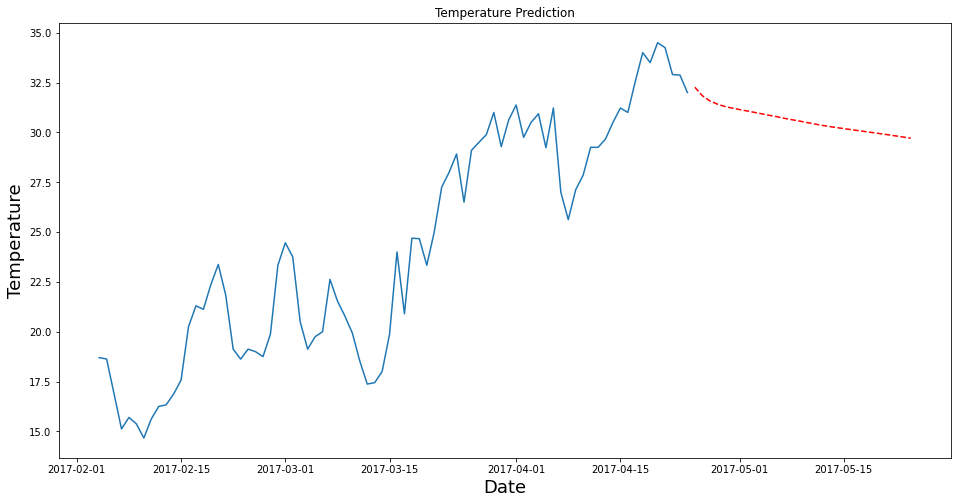

In [173]:
plt.figure(figsize=(16,8))
plt.title('Temperature Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Temperature' ,fontsize=18)
plt.plot(df[' _tempm'][7400:])
plt.plot(df_result.set_index('Date')[['Forecasted']],"r--")